<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/ClassificationTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter
import xgboost as xgb

# Tensorflow é a implementação padrão dos modelos de DL, ele é base do Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

### Algoritmos

In [ ]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [ ]:
def BlockSplit(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [ ]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [ ]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [ ]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = clf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [ ]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = rf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [93]:
def elbowAll(dflist, seed, n_songs):
  scorelistKNN = []
  scorelistDT = []
  scorelistRF = []
  scorelistSVM = []
  scorelistXGB = []
  scorelistMLP = []

  scorelistKNNB = []
  scorelistDTB = []
  scorelistRFB = []
  scorelistSVMB = []
  scorelistXGBB = []

  for df in dflist:

    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    neigh = neighbors.KNeighborsClassifier()
    clf = tree.DecisionTreeClassifier(random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)
    svmc = svm.SVC(random_state=seed)
    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)

    #MLP
    mlpModel = Sequential()
    mlpModel.add(Dense())
    mlpModel.add(Dense(10))

    mlpModel.compile()


    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict3 = neigh.predict(X.iloc[X.index.isin(test),:])

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

    svmc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictSVM = svmc.predict(X.iloc[X.index.isin(test),:])

    xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

    mlpModel.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])


    scorelistKNN.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
    scorelistDT.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
    scorelistRF.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
    scorelistSVM.append(balanced_accuracy_score(Y.iloc[test], Y_predictSVM))
    scorelistXGB.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))
    scorelistMLP.append(mlpModel.evaluate(X.iloc[X.index.isin(test),:], Y.iloc[test]))

    scorelistKNNB.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
    scorelistDTB.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
    scorelistRFB.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))
    scorelistSVMB.append(blockBalancedScore(Y.iloc[test], Y_predictSVM, n_songs))
    scorelistXGBB.append(blockBalancedScore(Y.iloc[test], Y_predictXGB, n_songs))


  return scorelistKNN, scorelistDT, scorelistRF, scorelistSVM, scorelistXGB, scorelistMLP,scorelistKNNB, scorelistDTB, scorelistRFB, scorelistSVMB, scorelistXGBB

### Testes

In [ ]:
#Ler CSVs
dflist = []

csvnames = ['256.csv', '512.csv','1024.csv','2048.csv','4096.csv','8192.csv']

for i in csvnames:
  dir_path = os.path.join('F:/Documentos/UTFPR/IC/csvs/ft2/3s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [ ]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores = []
dtscores = []
rfscores = []
svmscores = []
xgbscores = []

knnscoresB = []
dtscoresB = []
rfscoresB = []
svmscoresB = []
xgbscoresB = []

seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
# seeds = [14, 42, 60]


# for seed in seeds:
#   knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
#   knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
#   knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

#   dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
#   rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

for seed in seeds:
  knn, dt, rf, svmc, xgbc, knnB, dtB, rfB, svmcB, xgbcB = elbowAll(dflist, seed = seed, n_songs=1000)

  knnscores.append(knn)
  dtscores.append(dt)
  rfscores.append(rf)
  svmscores.append(svmc)
  xgbscores.append(xgbc)

  knnscoresB.append(knnB)
  dtscoresB.append(dtB)
  rfscoresB.append(rfB)
  svmscoresB.append(svmcB)
  xgbscoresB.append(xgbcB)

In [ ]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslistB = []
scoresmeansB = []
scoressdsB = []

scoreslist.append(np.array(knnscores))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))
scoreslist.append(np.array(svmscores))
scoreslist.append(np.array(xgbscores))

scoreslistB.append(np.array(knnscoresB))
scoreslistB.append(np.array(dtscoresB))
scoreslistB.append(np.array(rfscoresB))
scoreslistB.append(np.array(svmscoresB))
scoreslistB.append(np.array(xgbscoresB))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

for score in scoreslistB:
  scoresmeansB.append(np.mean(score, axis=0))
  scoressdsB.append(np.std(score, axis=0))

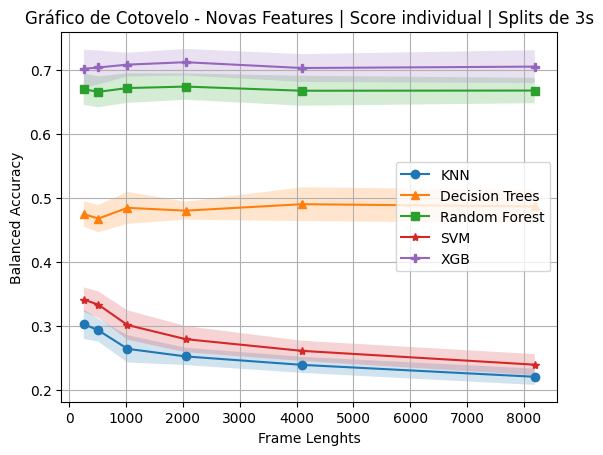

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Novas Features | Score individual | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('3s_new.pdf')
plt.show()

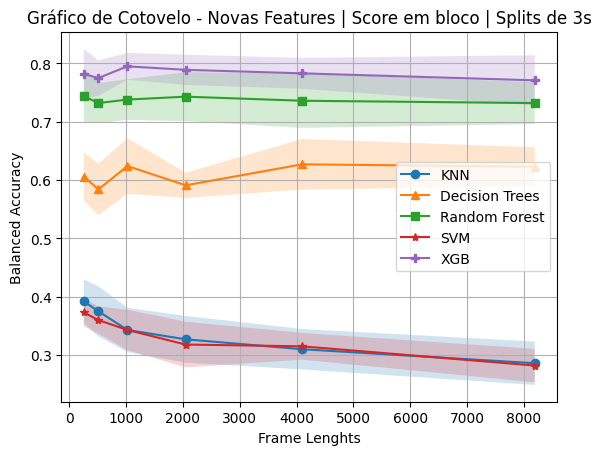

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeansB)):
  plt.plot(frame_lenghts, scoresmeansB[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeansB[i] + scoressdsB[i], scoresmeansB[i] - scoressdsB[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Novas Features | Score em bloco | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('3s_new_block.pdf')
plt.show()

### Testezao

In [ ]:
print(df.iloc[:,df.columns.get_loc('Classe')].shape)
print(len(all_rock))
dflist[0].shape

(5000,)
1


(5000, 2114)

In [ ]:
same_scores = []
random_scores = []

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for df in dflist:
  all_rock = ['rock' for _ in range(df.shape[0])]
  all_random = [random.choice(genres) for _ in range(df.shape[0])]
  same_scores.append(balanced_accuracy_score(df.iloc[:,df.columns.get_loc('Classe')], all_rock))
  random_scores.append(balanced_accuracy_score(df.iloc[:,df.columns.get_loc('Classe')], all_random))

print(same_scores)
print(random_scores)


[0.1, 0.1, 0.1, 0.1, 0.1]
[0.1024, 0.09759999999999999, 0.1026, 0.0968, 0.1004]


In [ ]:
all_rock = ['rock']*dflist[0].shape[0]

In [ ]:
Y_predict = [1,2,3,4,4,5,6,7,8,4,1,1,1,1,1,1,1,1,1,1,2,3,4,5,3,3,3,3,7,8]

Y_real = 0

blockBalancedScore(Y_predict, Y_real, 3)

[4, 1, 3]


In [ ]:
len(Y_predict)

30